In [1]:
!pip install --upgrade category_encoders
!pip install lightgbm
!pip install xgboost
!pip install graphviz
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import category_encoders as ce
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV
import pytz

In [2]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

In [3]:
train_labels = train_transaction[["TransactionID","isFraud"]]

In [4]:
train_transaction = train_transaction.merge(train_identity,on="TransactionID",how='outer')
test_transaction = test_transaction.merge(test_identity,on="TransactionID",how='outer')

In [5]:
test_transaction.columns = test_transaction.columns.str.replace('id-','id_')

In [6]:
test_transaction = test_transaction[["TransactionID","TransactionDT","TransactionAmt","ProductCD","card1","card2","card3","card4","card5","card6",\
                          "addr1","addr2","dist1","dist2","P_emaildomain","R_emaildomain","M1","M2","M3","M4","M5",\
                          "M6","M7","M8","M9","C1","C2","C3","C4","C5","C6","C7",\
                          "C8","C9","C10","C11","C12","C13","C14","D1","D2","D3","D4",\
                          "D5","D6","D7","D8","D9","D10","D11","D12","D13","D14","D15",\
                          "V15","V29","V30","V32","V33","V44","V45","V56","V57","V58",\
                          "V65","V69","V70","V72","V88","V90","V91","V102","V124","V149","V154",\
                          "V156","V186","V187","V188","V189","V194","V195","V200","V201","V242","V243",\
                          "V244","V245","V246","V257","V258","V268","V283","V294","V295","V302","V324",\
                          "id_01","id_02","id_03","id_04","id_05","id_06","id_07","id_08","id_09","id_10","id_11",\
                          "id_12","id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22",\
                          "id_23","id_24","id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32",\
                          "id_33","id_34","id_35","id_36","id_37","id_38","DeviceType","DeviceInfo"]]

train_transaction = train_transaction[["TransactionID","isFraud","TransactionDT","TransactionAmt","ProductCD","card1","card2","card3","card4","card5","card6",\
                          "addr1","addr2","dist1","dist2","P_emaildomain","R_emaildomain","M1","M2","M3","M4","M5",\
                          "M6","M7","M8","M9","C1","C2","C3","C4","C5","C6","C7",\
                          "C8","C9","C10","C11","C12","C13","C14","D1","D2","D3","D4",\
                          "D5","D6","D7","D8","D9","D10","D11","D12","D13","D14","D15",\
                          "V15","V29","V30","V32","V33","V44","V45","V56","V57","V58",\
                          "V65","V69","V70","V72","V88","V90","V91","V102","V124","V149","V154",\
                          "V156","V186","V187","V188","V189","V194","V195","V200","V201","V242","V243",\
                          "V244","V245","V246","V257","V258","V268","V283","V294","V295","V302","V324",\
                          "id_01","id_02","id_03","id_04","id_05","id_06","id_07","id_08","id_09","id_10","id_11",\
                          "id_12","id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22",\
                          "id_23","id_24","id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32",\
                          "id_33","id_34","id_35","id_36","id_37","id_38","DeviceType","DeviceInfo"]]



In [7]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [8]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train_transaction = pd.get_dummies(train_transaction, columns =['ProductCD'])
test_transaction = pd.get_dummies(test_transaction, columns =['ProductCD'])

In [10]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card4,card5,card6,...,id_36,id_37,id_38,DeviceType,DeviceInfo,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2987000,0,86400,68.5,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
1,2987001,0,86401,29.0,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
2,2987002,0,86469,59.0,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
3,2987003,0,86499,50.0,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
4,2987004,0,86506,50.0,4497,514.0,150.0,mastercard,102.0,credit,...,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,1,0,0,0


In [11]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card4,card5,card6,addr1,...,id_36,id_37,id_38,DeviceType,DeviceInfo,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,3663549,18403224,31.95,10409,111.0,150.0,visa,226.0,debit,170.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
1,3663550,18403263,49.00,4272,111.0,150.0,visa,226.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
2,3663551,18403310,171.00,4476,574.0,150.0,visa,226.0,debit,472.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
3,3663552,18403310,284.95,10989,360.0,150.0,visa,166.0,debit,205.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
4,3663553,18403317,67.95,18018,452.0,150.0,mastercard,117.0,debit,264.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1


In [12]:
categorias = train_transaction[['isFraud', 'card1', \
                                 'card2', 'card3', 'card4',\
                                 'card5',"card6", 'addr1', 'addr2',\
                                 'P_emaildomain', 'R_emaildomain','M1',\
                                 'M2','M3','M4','M5','M6','M7','M8','M9',
                                 'DeviceType','DeviceInfo',\
                                 'id_12','id_13','id_14','id_15','id_16',\
                                 'id_17','id_18','id_19','id_20','id_21','id_22',\
                                 'id_23','id_24','id_25','id_26','id_27','id_28',\
                                 'id_29','id_30','id_31','id_32','id_33','id_34',\
                                 'id_35','id_36','id_37','id_38']]

train_transaction = train_transaction.drop(columns =['card1', \
                                 'card2', 'card3', 'card4',\
                                 'card5',"card6", 'addr1', 'addr2',\
                                 'P_emaildomain', 'R_emaildomain','M1',\
                                 'M2','M3','M4','M5','M6','M7','M8','M9',
                                 'DeviceType','DeviceInfo',\
                                 'id_12','id_13','id_14','id_15','id_16',\
                                 'id_17','id_18','id_19','id_20','id_21','id_22',\
                                 'id_23','id_24','id_25','id_26','id_27','id_28',\
                                 'id_29','id_30','id_31','id_32','id_33','id_34',\
                                 'id_35','id_36','id_37','id_38'] )

categorias2 = test_transaction[['card1', \
                                 'card2', 'card3', 'card4',\
                                 'card5',"card6", 'addr1', 'addr2',\
                                 'P_emaildomain', 'R_emaildomain','M1',\
                                 'M2','M3','M4','M5','M6','M7','M8','M9',
                                 'DeviceType','DeviceInfo',\
                                 'id_12','id_13','id_14','id_15','id_16',\
                                 'id_17','id_18','id_19','id_20','id_21','id_22',\
                                 'id_23','id_24','id_25','id_26','id_27','id_28',\
                                 'id_29','id_30','id_31','id_32','id_33','id_34',\
                                 'id_35','id_36','id_37','id_38']]
test_transaction = test_transaction.drop(columns =[ 'card1', \
                                 'card2', 'card3', 'card4',\
                                 'card5',"card6", 'addr1', 'addr2',\
                                 'P_emaildomain', 'R_emaildomain','M1',\
                                 'M2','M3','M4','M5','M6','M7','M8','M9',
                                 'DeviceType','DeviceInfo',\
                                 'id_12','id_13','id_14','id_15','id_16',\
                                 'id_17','id_18','id_19','id_20','id_21','id_22',\
                                 'id_23','id_24','id_25','id_26','id_27','id_28',\
                                 'id_29','id_30','id_31','id_32','id_33','id_34',\
                                 'id_35','id_36','id_37','id_38'] )

In [13]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,...,id_07,id_08,id_09,id_10,id_11,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2987000,0,86400,68.5,19.0,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
1,2987001,0,86401,29.0,NaN,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
2,2987002,0,86469,59.0,287.0,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
3,2987003,0,86499,50.0,NaN,NaN,2.0,5.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
4,2987004,0,86506,50.0,NaN,NaN,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,100.0,0,1,0,0,0


In [14]:
categorias.head()

,isFraud,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,0,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,...,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [15]:
categorias2.head()

,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,gmail.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,aol.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,hotmail.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,gmail.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,gmail.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
for (columnName, columnData) in categorias.iteritems():
    if columnName != 'isFraud':
       aux = categorias.groupby([columnName])['isFraud'].mean().to_dict()
       categorias[columnName] =  categorias[columnName].map(aux)
       categorias2[columnName] = categorias2[columnName].map(aux)

In [19]:
from sklearn.impute import SimpleImputer
imp=SimpleImputer(strategy="mean",missing_values=np.NaN)
idf=pd.DataFrame(imp.fit_transform(train_transaction))
idf.columns=train_transaction.columns
idf.index=train_transaction.index

In [20]:
train_transaction = idf

In [21]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,...,id_07,id_08,id_09,id_10,id_11,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2987000.0,0.0,86400.0,68.5,19.00000,231.855423,1.0,1.0,0.0,0.0,...,13.285354,-38.600388,0.091023,-0.301124,99.745325,0.0,0.0,0.0,0.0,1.0
1,2987001.0,0.0,86401.0,29.0,118.50218,231.855423,1.0,1.0,0.0,0.0,...,13.285354,-38.600388,0.091023,-0.301124,99.745325,0.0,0.0,0.0,0.0,1.0
2,2987002.0,0.0,86469.0,59.0,287.00000,231.855423,1.0,1.0,0.0,0.0,...,13.285354,-38.600388,0.091023,-0.301124,99.745325,0.0,0.0,0.0,0.0,1.0
3,2987003.0,0.0,86499.0,50.0,118.50218,231.855423,2.0,5.0,0.0,0.0,...,13.285354,-38.600388,0.091023,-0.301124,99.745325,0.0,0.0,0.0,0.0,1.0
4,2987004.0,0.0,86506.0,50.0,118.50218,231.855423,1.0,1.0,0.0,0.0,...,13.285354,-38.600388,0.091023,-0.301124,100.000000,0.0,1.0,0.0,0.0,0.0


In [22]:
imp=SimpleImputer(strategy="mean",missing_values=np.NaN)
idf=pd.DataFrame(imp.fit_transform(test_transaction))
idf.columns=test_transaction.columns
idf.index=test_transaction.index

In [23]:
test_transaction = idf

In [24]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,id_07,id_08,id_09,id_10,id_11,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,3663549.0,18403224.0,31.95,1.0,237.175047,6.0,6.0,0.0,0.0,3.0,...,12.49318,-36.577782,0.076219,-0.245877,99.750876,0.0,0.0,0.0,0.0,1.0
1,3663550.0,18403263.0,49.00,4.0,237.175047,3.0,2.0,0.0,0.0,0.0,...,12.49318,-36.577782,0.076219,-0.245877,99.750876,0.0,0.0,0.0,0.0,1.0
2,3663551.0,18403310.0,171.00,2635.0,237.175047,2.0,2.0,0.0,0.0,0.0,...,12.49318,-36.577782,0.076219,-0.245877,99.750876,0.0,0.0,0.0,0.0,1.0
3,3663552.0,18403310.0,284.95,17.0,237.175047,5.0,2.0,0.0,0.0,1.0,...,12.49318,-36.577782,0.076219,-0.245877,99.750876,0.0,0.0,0.0,0.0,1.0
4,3663553.0,18403317.0,67.95,6.0,237.175047,6.0,6.0,0.0,0.0,2.0,...,12.49318,-36.577782,0.076219,-0.245877,99.750876,0.0,0.0,0.0,0.0,1.0


In [25]:
categorias = categorias.drop(columns =["isFraud"] )

In [26]:
from sklearn.impute import SimpleImputer
imp=SimpleImputer(strategy="most_frequent",missing_values=np.NaN)
idf=pd.DataFrame(imp.fit_transform(categorias))
idf.columns=categorias.columns
idf.index=categorias.index

In [27]:
categorias = idf

In [28]:
imp=SimpleImputer(strategy="most_frequent",missing_values=np.NaN)
idf=pd.DataFrame(imp.fit_transform(categorias2))
idf.columns=categorias2.columns
idf.index=categorias2.index

In [29]:
categorias2 = idf

In [30]:
train_transaction = train_transaction.join(categorias)
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,2987000.0,0.0,86400.0,68.5,19.00000,231.855423,1.0,1.0,0.0,0.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
1,2987001.0,0.0,86401.0,29.0,118.50218,231.855423,1.0,1.0,0.0,0.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
2,2987002.0,0.0,86469.0,59.0,287.00000,231.855423,1.0,1.0,0.0,0.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
3,2987003.0,0.0,86499.0,50.0,118.50218,231.855423,2.0,5.0,0.0,0.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
4,2987004.0,0.0,86506.0,50.0,118.50218,231.855423,1.0,1.0,0.0,0.0,...,0.051338,0.057820,0.070688,0.066727,0.053309,0.039293,0.044683,0.081885,0.083312,0.059541


In [31]:
test_transaction = test_transaction.join(categorias2)
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,3663549.0,18403224.0,31.95,1.0,237.175047,6.0,6.0,0.0,0.0,3.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
1,3663550.0,18403263.0,49.00,4.0,237.175047,3.0,2.0,0.0,0.0,0.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
2,3663551.0,18403310.0,171.00,2635.0,237.175047,2.0,2.0,0.0,0.0,0.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
3,3663552.0,18403310.0,284.95,17.0,237.175047,5.0,2.0,0.0,0.0,1.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
4,3663553.0,18403317.0,67.95,6.0,237.175047,6.0,6.0,0.0,0.0,2.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792


In [32]:
#df_test_encoding = df_test_encoding.iloc[:,1:]
X = train_transaction.iloc[:, 2:]
y = train_labels.iloc[:, 1:]

In [33]:
X.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,86400.0,68.5,19.00000,231.855423,1.0,1.0,0.0,0.0,0.0,1.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
1,86401.0,29.0,118.50218,231.855423,1.0,1.0,0.0,0.0,0.0,1.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
2,86469.0,59.0,287.00000,231.855423,1.0,1.0,0.0,0.0,0.0,1.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
3,86499.0,50.0,118.50218,231.855423,2.0,5.0,0.0,0.0,0.0,4.0,...,0.104463,0.031056,0.068318,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
4,86506.0,50.0,118.50218,231.855423,1.0,1.0,0.0,0.0,0.0,1.0,...,0.051338,0.057820,0.070688,0.066727,0.053309,0.039293,0.044683,0.081885,0.083312,0.059541


In [34]:
y.head()

,isFraud
0,0
1,0
2,0
3,0
4,0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [36]:
#MODELO 1
xgb_cl = xgb.XGBClassifier(min_child_weight= 5, 
                           learning_rate= 0.1, 
                           gamma= 0.05, 
                           subsample= 0.8,
                           colsample_bytree= 0.3, 
                           colsample_bynode= 0.8,
                           colsample_bylevel= 0.8, 
                           max_depth = 20, 
                           n_estimators = 150)

In [ ]:
 param_grid = {
        "max_depth": [3,10,20],
        "learning_rate": [0.1,0.05],
        "gamma": [0.05,0.25],
 }

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3)


_ = grid_cv.fit(X_train,y_train)
xgb_cl.fit(X_train,y_train)

In [37]:
xgb_cl.fit(X_train,y_train)

C:\Users\Pato\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Pato\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[19:14:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.8, colsample_bytree=0.3, gamma=0.05, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
pred_xgboost = xgb_cl.predict(X_test)

In [39]:
xgb_cl.feature_importances_

array([0.00310827, 0.00324489, 0.0032569 , 0.00275499, 0.00722264,
       0.00412942, 0.00742403, 0.00851083, 0.00460336, 0.00461803,
       0.00520672, 0.00601253, 0.00400669, 0.00669287, 0.00621454,
       0.00828802, 0.00613674, 0.00808434, 0.00348738, 0.0043312 ,
       0.00336985, 0.00291858, 0.00237222, 0.00353501, 0.00369552,
       0.00315247, 0.00212048, 0.00316424, 0.00279804, 0.00315313,
       0.00388613, 0.00239566, 0.00317323, 0.00590947, 0.00875009,
       0.00628957, 0.00775105, 0.00387938, 0.00663303, 0.00540313,
       0.00378723, 0.00666984, 0.00515582, 0.0091715 , 0.00623661,
       0.01062833, 0.00599723, 0.00289543, 0.00646375, 0.00793078,
       0.00931777, 0.0050343 , 0.01333484, 0.00488107, 0.02121846,
       0.00440128, 0.00512984, 0.0210381 , 0.03610794, 0.00722419,
       0.00570241, 0.03765025, 0.02439373, 0.00581716, 0.0310121 ,
       0.03489821, 0.00254092, 0.04101431, 0.06566601, 0.03737712,
       0.00693575, 0.0069178 , 0.00862321, 0.00897987, 0.00353

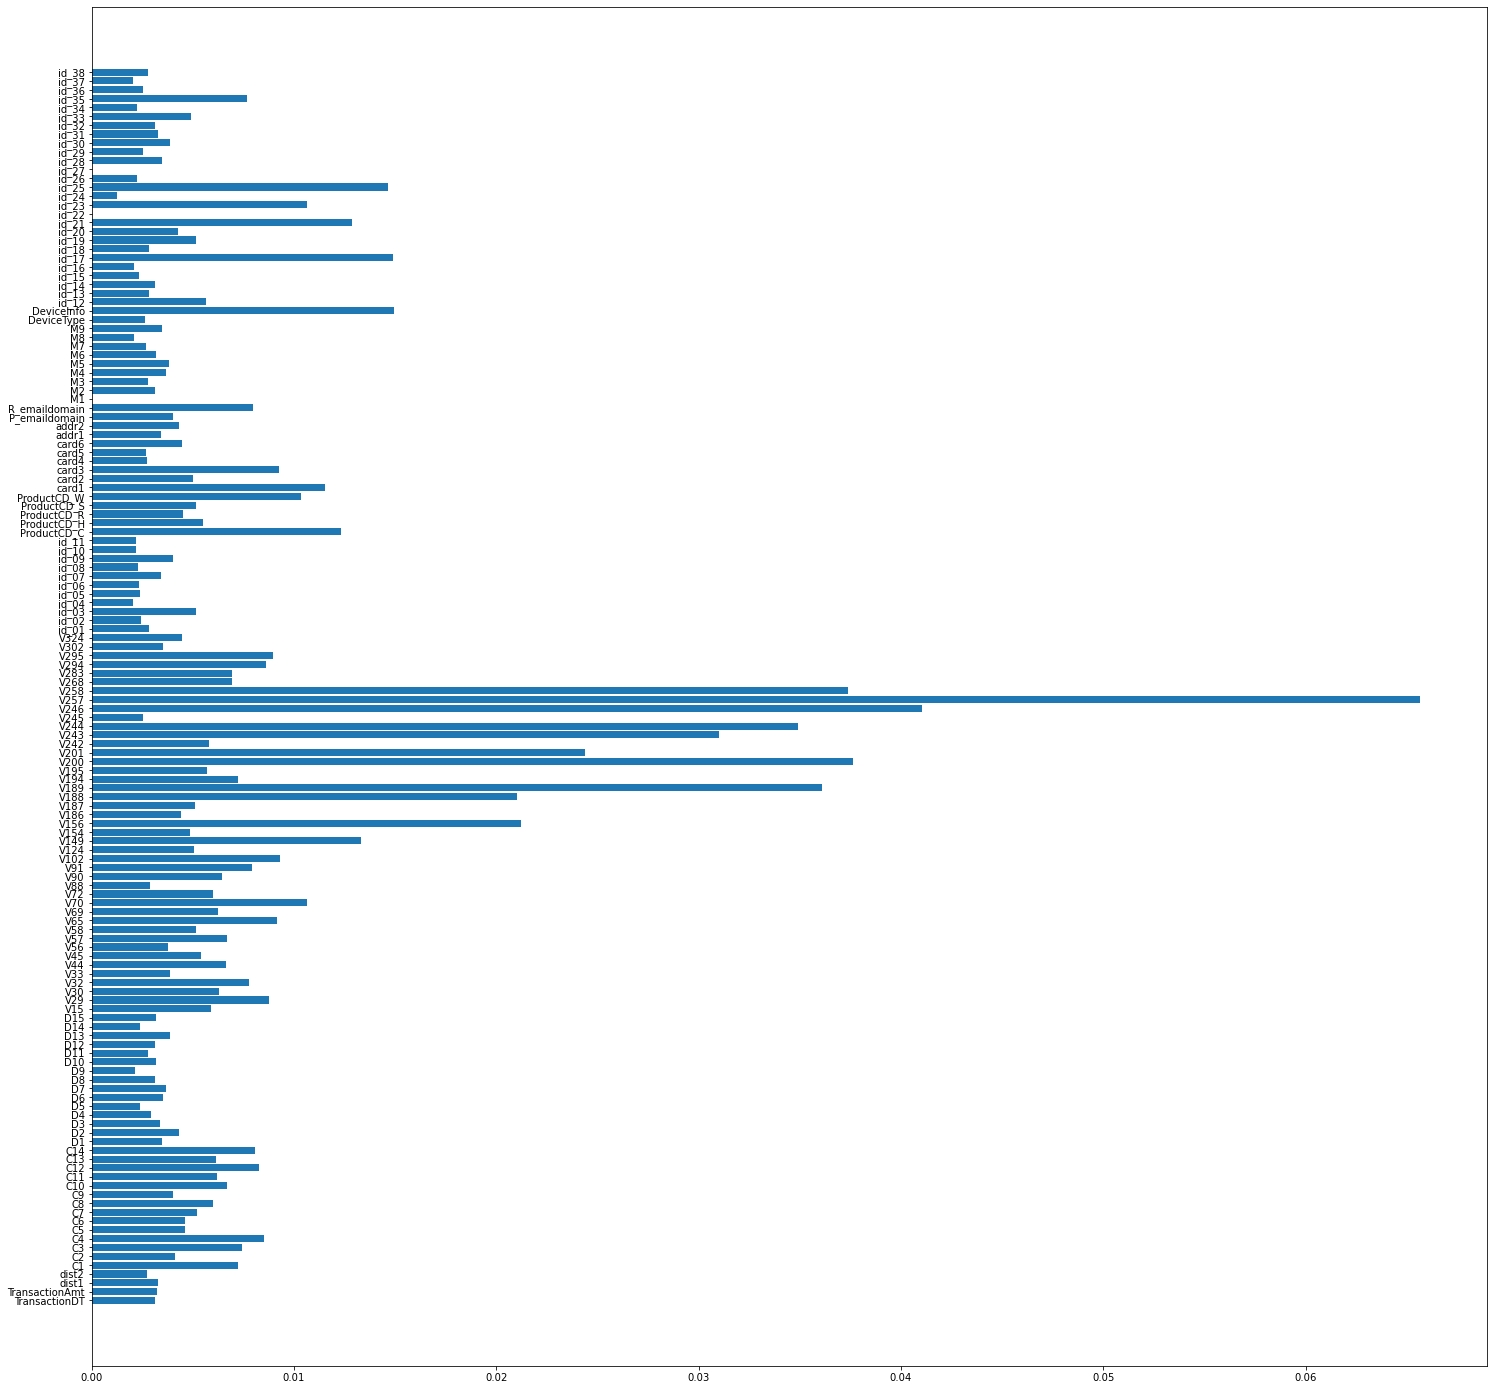

In [40]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, xgb_cl.feature_importances_)
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, xgb_cl.predict_proba(X_test)[:,1])
print(auc)

0.9755469618941239


In [42]:
print(roc_auc_score(train_labels["isFraud"], xgb_cl.predict_proba(X)[:,1]))


0.9922704304855726


In [44]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,3663549.0,18403224.0,31.95,1.0,237.175047,6.0,6.0,0.0,0.0,3.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
1,3663550.0,18403263.0,49.00,4.0,237.175047,3.0,2.0,0.0,0.0,0.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
2,3663551.0,18403310.0,171.00,2635.0,237.175047,2.0,2.0,0.0,0.0,0.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
3,3663552.0,18403310.0,284.95,17.0,237.175047,5.0,2.0,0.0,0.0,1.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
4,3663553.0,18403317.0,67.95,6.0,237.175047,6.0,6.0,0.0,0.0,2.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792


In [46]:
pred_xgboost = xgb_cl.predict(test_transaction.iloc[:, 1:])

In [47]:
submission_format = pd.read_csv('sample_submission.csv', index_col='TransactionID')
my_submission = pd.DataFrame(data=pred_xgboost,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [48]:
my_submission.to_csv('XGBresult.csv',index= True)

In [ ]:
########################################################################################
########################################################################################

In [ ]:
#MODELO 2
#####################

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓


<ipython-input-49-f2223f84ddf0>:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


Modelo: {'max_depth': 20, 'max_features': 9, 'n_estimators': 150} ✓


In [50]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head()

,oob_r2,max_depth,max_features,n_estimators
2,0.983695,NaN,9.0,150.0
1,0.983500,NaN,7.0,150.0
0,0.982908,NaN,5.0,150.0
11,0.980230,20.0,9.0,150.0
10,0.979625,20.0,7.0,150.0


In [51]:
resultados.head(12)

,oob_r2,max_depth,max_features,n_estimators
2,0.983695,NaN,9.0,150.0
1,0.983500,NaN,7.0,150.0
0,0.982908,NaN,5.0,150.0
11,0.980230,20.0,9.0,150.0
10,0.979625,20.0,7.0,150.0
9,0.978710,20.0,5.0,150.0
8,0.974760,10.0,9.0,150.0
7,0.974036,10.0,7.0,150.0
6,0.973353,10.0,5.0,150.0
5,0.969090,3.0,9.0,150.0


In [52]:
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.9836950079588174 : 0.9836950079588174 R2


In [53]:
modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                max_features = 20,
                n_estimators = 150
                 )
    
modelo.fit(X_train, y_train)

<ipython-input-53-b8689d6af5ae>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo.fit(X_train, y_train)


RandomForestClassifier(max_features=20, n_estimators=150, n_jobs=-1,
                       oob_score=True, random_state=123)

In [54]:
prediccion = modelo.predict(X_test)

In [55]:
auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1])

In [56]:
print(auc)

0.9628416340859993


In [57]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,3663549.0,18403224.0,31.95,1.0,237.175047,6.0,6.0,0.0,0.0,3.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
1,3663550.0,18403263.0,49.00,4.0,237.175047,3.0,2.0,0.0,0.0,0.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
2,3663551.0,18403310.0,171.00,2635.0,237.175047,2.0,2.0,0.0,0.0,0.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
3,3663552.0,18403310.0,284.95,17.0,237.175047,5.0,2.0,0.0,0.0,1.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792
4,3663553.0,18403317.0,67.95,6.0,237.175047,6.0,6.0,0.0,0.0,2.0,...,0.104463,0.031056,0.0,0.033917,0.029039,0.039293,0.044683,0.081885,0.083312,0.097792


In [58]:
prediccion_forest = modelo.predict(test_transaction.iloc[:, 1:])

In [59]:
submission_format = pd.read_csv('sample_submission.csv', index_col='TransactionID')
my_submission = pd.DataFrame(data=prediccion_forest,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [60]:
my_submission.to_csv('RFresult.csv',index= True)